# 10_Process and thread

- 真正的并行执行多任务只能在多核CPU上实现，但是，由于任务数量远远多于CPU的核心数量，所以，操作系统也会自动把很多任务轮流调度到每个核心上执行。
- 一个任务就是一个进程（Process），比如打开一个浏览器就是启动一个浏览器进程，打开一个记事本就启动了一个记事本进程，打开两个记事本就启动了两个记事本进程，打开一个Word就启动了一个Word进程。
- 进程内的“子任务”称为线程（Thread），比如Word同时进行打字，拼写检查等任务。一个进程至少有一个线程。当然，像Word这种复杂的进程可以有多个线程，多个线程可以同时执行，由操作系统在多线程之间快速切换。

我们前面编写的所有的Python程序，都是执行单任务的进程，也就是只有一个线程。如果我们要同时执行多个任务怎么办？  

三种解决方法：
1. **多进程**：启动多个进程，每个进程虽然只有一个线程，多进程可以执行多任务
2. **多线程**：启动一个进程，在一个进程内启动多个线程
3. **多进程+多线程**启动多个进程和多个线程    

一般情况下不会用第三种，因为模型复杂，调试困难。

总结:  
- 线程是最小的执行单元，而进程由至少一个线程组成。如何调度进程和线程，完全由操作系统决定，程序自己不能决定什么时候执行，执行多长时间。
- 多进程和多线程的程序涉及到同步、数据共享的问题，编写起来更复杂。

## 10.1 多进程 (multiprocessing)

**fork()**

`fork()`在Unix/Linux系统中提供，Mac系统是基于BSD(Unix的一种)内核，在Mac上也可运行，而Windows中没有。

如何在Windows上编写多进程的程序?  
`multiprocessing`模块中`Process`类代表一个进程对象

**1. multiprocessing**

In [1]:
from multiprocessing import Process
import os

#子进程要执行的代码
def run_proc(name):
    print('Run child process %s (%s)...' % (name,os.getpid()))  #os.getpid - get process id
    
if __name__ == '__main__':
    print('Parent process %s.' % os.getpid())  
    p = Process(target=run_proc,args=('test',))  #创建Process实例
    print('Child process will start.')
    p.start()  #启动进程
    p.join()  #等待子进程结束后再继续往下运行，通常用于进程间的同步
    print('Child process end')

Parent process 7776.
Child process will start.
Child process end


**2. Pool**  
用于批量创建子进程

random.random()和random.Random()的区别:  
- random.random()用于生成0和1之间的浮点数
- random.Random()用于生成random模块里的Random类的一个实例，一般会在多线程的情况下使用

```python
#mp_1.py
from multiprocessing import Pool
import os,time,random

def long_time_task(name):
    print('Run task %s (%s)...' % (name, os.getpid()))
    start = time.time()
    time.sleep(random.random() * 3)
    end = time.time()
    print('Task %s runs %0.2f seconds.' % (name, (end - start)))

if __name__=='__main__':
    print('Parent process %s.' % os.getpid())
    p = Pool(4)
    for i in range(5):
        p.apply_async(long_time_task, args=(i,))
    print('Waiting for all subprocesses done...')
    p.close()  #调用close()之后不能继续添加新的Process了
    p.join()  #等待，调用join之前必须先调用close
    print('All subprocesses done.')  
```

```
Result:  
Parent process 3316.
Waiting for all subprocesses done...
Run task 0 (12464)...
Run task 1 (5088)...
Run task 2 (23308)...
Run task 3 (1084)...
Task 0 runs 1.27 seconds.
Run task 4 (12464)...
Task 4 runs 0.17 seconds.
Task 2 runs 2.29 seconds.
Task 1 runs 2.31 seconds.
Task 3 runs 2.75 seconds.
All subprocesses done.
```

该程序无法在jupyter notebook中运行，保存文件为"mp_1.py"。task 0，1，2，3是立刻执行的，而task 4要等待前面某个task完成后才执行，这是因为Pool的默认大小为CPU的核数，因此，最多同时执行4个进程。如果需要同时跑5个进程，则改为Pool(5)。

**3. 子进程**

子进程通常为一个外部进程，`subprocess`模块可以让我们非常方便地启动一个子进程，然后控制其输入和输出。

例：在Python代码中运行命令`nslookup www.python.org`

```
#mp_2.py
import subprocess

print('$ nslookup www.python.org')
r = subprocess.call(['nslookup', 'www.python.org'])
print('Exit code:', r)
```

**cmd中运行`nslookup www.python.org`：**
```
服务器:  UnKnown
Address:  192.168.1.1

非权威应答:
名称:    dualstack.python.map.fastly.net
Addresses:  2a04:4e42:1b::223
          151.101.112.223
Aliases:  www.python.org  
```
**pycharm运行：** 

```
$ nslookup www.python.org
��Ȩ��Ӧ��:
������:  UnKnown
Address:  192.168.1.1

����:    dualstack.python.map.fastly.net
Addresses:  2a04:4e42:1b::223
	  151.101.112.223
Aliases:  www.python.org

Exit code: 0
```
乱码是因为是中文

如果子进程还需要输入，则可以通过communicate()方法输入：

```
import subprocess

print('$ nslookup')
p = subprocess.Popen(['nslookup'], stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)  #创建子进程实例
output, err = p.communicate(b'set q=mx\npython.org\nexit\n')  #和子进程交互
print(output.decode('utf-8'))
print('Exit code:', p.returncode)
```

解释一些语句：

1. subprocess.Popen

```
class subprocess.Popen( args, 
  bufsize=0, 
  executable=None,
  stdin=None,
  stdout=None, 
  stderr=None, 
  preexec_fn=None, 
  close_fds=False, 
  shell=False, 
  cwd=None, 
  env=None, 
  universal_newlines=False, 
  startupinfo=None, 
  creationflags=0)
 ```
- args - 列表形式或字符串形式  
- bufsize - 0为默认值，表示不缓冲，1表示缓冲  
- excutable - 表示要执行的程序，该参数很少用到
- stdin, stdout, stderr - 子程序的标准输入，标准输出和标准错误。PIPE表示创建一个新的管道；None表示不会做任何重定向工作，子进程的文件描述符会继承父进程的；还可以指定一个有效的文件描述符或一个文件对象。


subprocess.Popen(["cat","test.txt"]) #一般使用这种形式  
subprocess.Popen("cat test.txt") #字符串必须为程序的路

2. Popen.communicate

Popen.communicate(input=None)  
和子进程交互：发送数据到stdin，并从stdout和stderr读数据，直到收到EOF。等待子进程结束。可选的input如有有的话，要为字符串类型。

此函数返回一个元组： (stdoutdata , stderrdata ) 。

注意：
- 要给子进程的stdin发送数据，则Popen的时候，stdin要为PIPE；同理，要可以接收数据的话，stdout或者stderr也要为PIPE。
- 读到的数据会被缓存在内存里，当数据量大的时候要小心。

**4. 进程间通信**

Process之间肯定是需要通信的，操作系统提供了很多机制来实现进程间的通信。Python的multiprocessing模块包装了底层的机制，提供了Queue、Pipes等多种方式来交换数据。

我们以Queue为例，在父进程中创建两个子进程，一个往Queue里写数据，一个从Queue里读数据：

```
from multiprocessing import Process, Queue
import os, time, random

# 写数据进程执行的代码:
def write(q):
    print('Process to write: %s' % os.getpid())
    for value in ['A', 'B', 'C']:
        print('Put %s to queue...' % value)
        q.put(value)
        time.sleep(random.random())

# 读数据进程执行的代码:
def read(q):
    print('Process to read: %s' % os.getpid())
    while True:
        value = q.get(True)
        print('Get %s from queue.' % value)

if __name__=='__main__':
    # 父进程创建Queue，并传给各个子进程：
    q = Queue()  #队列中的项数无限制
    pw = Process(target=write, args=(q,))
    pr = Process(target=read, args=(q,))
    
    # 启动子进程pw，写入:
    pw.start()
    
    # 启动子进程pr，读取:
    pr.start()
    
    # 等待pw结束:
    pw.join()
    
    # pr进程里是死循环，无法等待其结束，只能强行终止:
    pr.terminate()
```

```
Process to write: 3024
Put A to queue...
Process to read: 15004
Get A from queue.
Put B to queue...
Get B from queue.
Put C to queue...
Get C from queue.

Process finished with exit code 0
```

## 10.2 多线程 (Multithreading)

- Python的线程是真正的Posix Thread，而不是模拟出来的线程
- Python的标准库提供了两个模块：`_thread`和`threading`，`_thread`是低级模块，`threading`是高级模块，对`_thread`进行了封装。

启动一个线程就是把一个函数传入并创建`Thread`实例，然后调用start()开始执行：

In [9]:
import time, threading

# 新线程执行的代码:
def loop():
    print('thread %s is running...' % threading.current_thread().name)
    n = 0
    while n < 5:
        n = n + 1
        print('thread %s >>> %s' % (threading.current_thread().name, n))
        time.sleep(1)
    print('thread %s ended.' % threading.current_thread().name)

print('thread %s is running...' % threading.current_thread().name)  #MainThread
t = threading.Thread(target=loop, name='LoopThread')
t.start()
t.join()
print('thread %s ended.' % threading.current_thread().name)

thread MainThread is running...
thread LoopThread is running...
thread LoopThread >>> 1
thread LoopThread >>> 2
thread LoopThread >>> 3
thread LoopThread >>> 4
thread LoopThread >>> 5
thread LoopThread ended.
thread MainThread ended.


`threading.current_thread()` - 返回当前线程的实例  
任何进程默认会启动一个线程，该线程称为主线程，主线程实例的名字为`MainThread`,主线程可以启动新的线程，称为子线程，子线程的名字在创建时指定，上例中用`LoopThread`来命名。

**1. Lock**

多线程和多进程最大的不同在于: 
- 多进程中，同一个变量，各自有一份拷贝存在于每个进程中，互不影响。
- 多线程中，所有变量都由所有线程共享，所以，任何一个变量都可以被任何一个线程修改。

线程之间共享数据最大的危险在于多个线程同时改一个变量，把内容给改乱了。

In [13]:
import time, threading

# 假定这是你的银行存款:
balance = 0

def change_it(n):
    # 先存后取，结果应该为0:
    global balance
    balance = balance + n
    balance = balance - n

def run_thread(n):
    for i in range(1000000000): 
        change_it(n)

t1 = threading.Thread(target=run_thread, args=(5,))
t2 = threading.Thread(target=run_thread, args=(8,))
t1.start()
t2.start()
t1.join()
t2.join()
print(balance)

3735


当循环数字很大的时候，balance就不一定为0了，原因在于一条语句在CPU执行时是若干条语句，即使是一个简单的计算也会分为两步：  
1. 计算`balance+n`,存入临时变量： `x=balance+n`
2. 将临时变量的值赋给`balance`: `balance=x`

由于x是局部变量，两个线程各自都有自己的x，当代码正常执行时：
```
初始值 balance = 0

t1: x1 = balance + 5 # x1 = 0 + 5 = 5
t1: balance = x1     # balance = 5
t1: x1 = balance - 5 # x1 = 5 - 5 = 0
t1: balance = x1     # balance = 0

t2: x2 = balance + 8 # x2 = 0 + 8 = 8
t2: balance = x2     # balance = 8
t2: x2 = balance - 8 # x2 = 8 - 8 = 0
t2: balance = x2     # balance = 0
    
结果 balance = 0
```

但是t1和t2是交替运行的，如果操作系统以下面的顺序执行t1、t2：  
```
初始值 balance = 0

t1: x1 = balance + 5  # x1 = 0 + 5 = 5

t2: x2 = balance + 8  # x2 = 0 + 8 = 8
t2: balance = x2      # balance = 8

t1: balance = x1      # balance = 5
t1: x1 = balance - 5  # x1 = 5 - 5 = 0
t1: balance = x1      # balance = 0

t2: x2 = balance - 8  # x2 = 0 - 8 = -8
t2: balance = x2   # balance = -8

结果 balance = -8
```

如何确保一个线程在修改`balance`的时候，别的线程不能改？  
`change_it()`相当于一把锁，当某个线程开始执行`change_it()`时，该线程已通过`lock.acquire()`获得了锁，因此其他线程不能同时执行，只能等待该锁被释放后，获得该锁才能改。创建一个锁通过`threading.Lock()`来实现。

In [14]:
balance = 0
lock = threading.Lock()

def run_thread(n):
    for i in range(100000):
        # 先要获取锁:
        lock.acquire()
        try:
            # 放心地改吧:
            change_it(n)
        finally:
            # 改完了一定要释放锁:
            lock.release()

分析锁的优点和缺点  
优点：确保某段关键代码从头到尾只能由一个线程完整执行  
缺点：阻止了多线程并发执行，效率下降；由于可以存在多个锁，不同的线程持有不同锁，并且试图获取对方的锁时，会造成死锁，导致多个线程既不能执行，也不能结束，只能靠系统强制终止。

**2. 多核CPU**

Windows的Task Manager,可以监控某个进程的CPU使用率，一个死循环线程会100%占用一个CPU。下面是一个python死循环：

In [15]:
import threading, multiprocessing

def loop():
    x = 0
    while True:
        x = x ^ 1

for i in range(multiprocessing.cpu_count()):
    t = threading.Thread(target=loop)
    t.start()

用C、C++或Java来改写相同的死循环，直接可以把全部核心跑满，4核就跑到400%，8核就跑到800%，为什么Python不行呢？  
因为Python的线程虽然是真正的线程，但解释器执行代码时，有一个GIL锁：Global Interpreter Lock，任何Python线程执行前，必须先获得GIL锁，然后，每执行100条字节码，解释器就自动释放GIL锁，让别的线程有机会执行。这个GIL全局锁实际上把所有线程的执行代码都给上了锁，所以，多线程在Python中只能交替执行，即使100个线程跑在100核CPU上，也只能用到1个核。

总结：
- python中，可以使用多线程，但不能指望能有效利用多核。
- 多线程编程，模型复杂，容易发生冲突，必须用锁加以隔离，同时，又要小心死锁的发生。

## 10.3 ThreadLocal

上节课中，多线程编程中需要特别小心变量改变，为防止变量改变，必须用锁加以隔离，但这种方式使效率降低。本节中介绍局部变量，只有线程本身可以看见，不会影响其他线程。

In [ ]:
def process_student(name):
    std = Student(name)
    # std是局部变量，但是每个函数都要用它，因此必须传进去：
    do_task_1(std)
    do_task_2(std)

def do_task_1(std):
    do_subtask_1(std)
    do_subtask_2(std)

def do_task_2(std):
    do_subtask_2(std)
    do_subtask_2(std)

我们发现每个函数都需要传参数`std`,用全局变量也不行，因为每个线程处理不同的`Student`对象，不能共享。

改进：  
用一个全局`dict`存放所有的`Student`对象，然后以`thread`自身作为`Key`获得线程对应的Student对象。

In [ ]:
global_dict = {}

def std_thread(name):
    std = Student(name)
    # 把std放到全局变量global_dict中：
    global_dict[threading.current_thread()] = std
    do_task_1()
    do_task_2()

def do_task_1():
    # 不传入std，而是根据当前线程查找：
    std = global_dict[threading.current_thread()]
    ...

def do_task_2():
    # 任何函数都可以查找出当前线程的std变量：
    std = global_dict[threading.current_thread()]

缺点：`threading.current_thread`太长，有点复杂

继续改进：  
那就是本节介绍主题啦！ -> `ThreadLocal`: 自动查找`dict`,

In [1]:
import threading
    
# 创建全局ThreadLocal对象:
local_school = threading.local()

def process_student():
    # 获取当前线程关联的student:
    std = local_school.student
    print('Hello, %s (in %s)' % (std, threading.current_thread().name))

def process_thread(name):
    # 绑定ThreadLocal的student:
    local_school.student = name
    process_student()

t1 = threading.Thread(target= process_thread, args=('Alice',), name='Thread-A')
t2 = threading.Thread(target= process_thread, args=('Bob',), name='Thread-B')
t1.start()
t2.start()
t1.join()
t2.join()

Hello, Alice (in Thread-A)
Hello, Bob (in Thread-B)


全局变量`local_school`就是一个`ThreadLocal`对象，每个`Thread`对它都可以读写student属性，但互不影响。你可以把local_school看成全局变量，但每个属性如local_school.student都是线程的局部变量，可以任意读写而互不干扰，也不用管理锁的问题，ThreadLocal内部会处理。

常用应用：  
- 每个线程绑定一个数据库连接
- HTTP请求
- 用户身份信息

一个`ThreadLocal`变量虽然是全局变量，但每个线程都只能读写自己线程的独立副本，互不干扰。`ThreadLocal`解决了参数在一个线程中各个函数之间互相传递的问题

## 10.4 进程 vs. 线程

**Master-Worker模式：**   
Master负责分配任务，Worker负责执行任务，因此，多任务环境下，通常是一个Master，多个Worker。  

**多进程：**
- 稳定性高，一个子进程崩溃，不会影响主进程和其他的子进程，Apache最早采用多进程模式。
- 但创建进程代价大

**多线程：**
- 一个线程挂掉，全盘皆输，因为所有线程共享进程的内存
- Windows下，多线程的效率比多进程要高，微软的IIS服务器即采用多线程模式，稳定性不如Apache

综合考虑多进程和多线程的优缺点，IIS和Apache现在有**多进程+多线程**的混合模式

### 1. 线程切换

**单任务模型/批处理任务模型：** 依次完成单个任务  
**多任务模型：**多个任务同时进行，需要在任务之间不停切换，但必须注意切换付出的代价。一旦任务数目达到限度，系统所有资源耗尽，效果急剧下降，所有任务都做不好。

### 2. 计算密集型 vs. IO密集型

任务分类：
1. **计算密集型**：进行大量的计算，消耗CPU资源。要最高效地利用CPU，计算密集型任务同时进行的数量应当等于CPU的核心数。  
2. **IO密集型**： 涉及到网络、磁盘IO的任务都是IO密集型任务，这类任务的特点是CPU消耗很少，任务的大部分时间都在等待IO操作完成（因为IO的速度远远低于CPU和内存的速度）。对于IO密集型任务，任务越多，CPU效率越高，但也有一个限度。常见的大部分任务都是IO密集型任务，比如Web应用。

关于IO密集型任务语言的选择：  
IO密集型任务的特点是IO上花的时间多，CPU上花的时间少，因此提升运行速度的语言（例如C语言）在IO密集型任务上是没用的。最适合的语言必须具有开发效率高（代码量少）的特点，因此脚本语言是首选。

什么是脚本语言？  
百度百科：https://baike.baidu.com/item/%E8%84%9A%E6%9C%AC%E8%AF%AD%E8%A8%80/1379708?fr=aladdin  
- 为了缩短传统的编写-编译-链接-运行（edit-compile-link-run）过程而创建的计算机编程语言。
- 一个脚本通常是解释执行而非编译，脚本语言具有简单、易学、易用的特性。  
- 常见脚本语言：Python，Javascript, vbscript...

### 3. 异步IO

https://baike.baidu.com/item/%E5%BC%82%E6%AD%A5IO  
异步IO的概念和同步IO相对。当一个异步过程调用发出后，调用者不能立刻得到结果。实际处理这个调用的部件在完成后，通过状态、通知和回调来通知调用者。在一个CPU密集型的应用中，有一些需要处理的数据可能放在磁盘上。预先知道这些数 据的位置，所以预先发起异步IO读请求。等到真正需要用到这些数据的时候，再等待异步IO完成。使用了异步IO，在发起IO请求到实际使用数据这段时间内，程序还可以继续做其他事情。

异步IO需要解决的问题：
- 检测数据到做出响应的时间差，容易遗漏前面数据。 -> 传输信息需要有起始位，给接收方响应、 接收和缓存的时间。
- 传输结束时，需要有停止位表示传输信息的终止。

现代操作系统对IO操作已经做了巨大的改进，最大的特点就是**支持异步IO**，可以用单进程单线程模型来执行多任务，这种模型称为**事件驱动模型**。  

对应到python语言，单线程的异步编程模型称为**携程**。

## 10.5 分布式进程

在Thread和Process中，应当优选Process：
- Process更稳定
- Process可以分布到多台机器上，Thread最多只能分布到同一台机器的多个CPU上

Python中, `multiprocessing`模块不但支持多进程，其中`managers`子模块支持把多进程分布到多台计算机上。

举例：如果我们已经有一个通过Queue通信的多进程程序在同一台机器上运行，现在，由于处理任务的进程任务繁重，希望把发送任务的进程和处理任务的进程分布到两台机器上。怎么用分布式进程实现？

原有的`Queue`（10.1中有讲到）可以继续使用，但是，通过`managers`模块把`Queue`通过网络暴露出去，就可以让其他机器的进程访问`Queue`了。


1. 服务进程负责启动`Queue` -> `QueueManager()`
2. 把`Queue`注册到网络上 -> `QueueManager.register()`
3. 启动`Queue` -> `manager.start()`
4. 往`Queue`里面写入任务 -> `task.put()/result.get()`

```
#task_master.py

import random, time, queue
from multiprocessing.managers import BaseManager  #BaseManger用于创建分布式管理器

# 发送任务的队列:
task_queue = queue.Queue()
# 接收结果的队列:
result_queue = queue.Queue()

# 从BaseManager继承的QueueManager:
class QueueManager(BaseManager):
    pass

# 把两个Queue都注册到网络上, callable参数关联了Queue对象:
QueueManager.register('get_task_queue', callable=lambda: task_queue)
QueueManager.register('get_result_queue', callable=lambda: result_queue)

# 绑定端口5000, 设置验证码'abc':
manager = QueueManager(address=('', 5000), authkey=b'abc') #参数'abc'是字节型

# 启动Queue:
manager.start()

# 获得通过网络访问的Queue对象:
task = manager.get_task_queue()  #必须通过这样获得的Queue接口进行操作
result = manager.get_result_queue()

# 放几个任务进去:
for i in range(10):
    n = random.randint(0, 10000)
    print('Put task %d...' % n)
    task.put(n)

# 从result队列读取结果:
print('Try get results...')
for i in range(10):
    r = result.get(timeout=10)
    print('Result: %s' % r)

# 关闭:
manager.shutdown()
print('master exit.')
```

http://www.manongjc.com/article/68040.html  
`multiprocessing.Queue()`（10.1节中）和`queue.Queue()`(本节中)的区别：    
- `multiprocessing.Queue()`:多进程并发的queue队列，用于解决多进程间的通信问题  
- `queue.Queue()`:Python中的标准库，默认队列先进先出

```
#task_worker.py

import time, sys, queue
from multiprocessing.managers import BaseManager

# 创建类似的QueueManager:
class QueueManager(BaseManager):
    pass

# 由于这个QueueManager只从网络上获取Queue，所以注册时只提供名字:
QueueManager.register('get_task_queue')
QueueManager.register('get_result_queue')

# 连接到服务器，也就是运行task_master.py的机器:
server_addr = '127.0.0.1'  #任务进程要通过网络连接，此处指定服务进程的IP
print('Connect to server %s...' % server_addr)

# 端口和验证码注意保持与task_master.py设置的完全一致:
m = QueueManager(address=(server_addr, 5000), authkey=b'abc')

# 从网络连接:
m.connect()

# 获取Queue的对象:
task = m.get_task_queue()
result = m.get_result_queue()

# 从task队列取任务,并把结果写入result队列:
for i in range(10):
    try:
        n = task.get(timeout=1)
        print('run task %d * %d...' % (n, n))
        r = '%d * %d = %d' % (n, n, n*n)
        time.sleep(1)
        result.put(r)
    except Queue.Empty:
        print('task queue is empty.')
# 处理结束:
print('worker exit.')
```

运行上面两段代码注意事项：
- 同一台电脑，需开两个cmd，一个运行`task_master.py`,一个运行`task_worker.py`
- 先运行`task_master.py`,再运行`task_worker.py`
- 上述代码为网站原代码，在Win10 64环境下会出现一些问题，解决方案如下

在Win10 64上运行的一些问题和解决办法： 
https://blog.csdn.net/u012783669/article/details/80596768?utm_source=blogxgwz2  
https://blog.csdn.net/xionghuixionghui/article/details/68491145  

1. 运行`task_manager.py`，报错`[WinError 87] 参数错误。`  
原因： windows10 64 不支持callable下调用匿名函数lambda
解决方法：封装

```python
#封装
def return_task_queue():
    global task_queue
    return task_queue

def return_result_queue():
    global result_queue
    return result_queue

def test():
    QueueManager.register('get_task_queue',callable=return_task_queue)
    QueueManager.register('get_result_queue',callable = return_result_queue)
```

2. `RuntimeError:The "freeze_support()" line can be omitted if the program is not going to be frozen to produce an executable.`   
解决方法：
- 开头加上`from multiprocessing import freeze_support`
- 结尾加上错误提示信息`freeze_support()`  

3. `OSError: [WinError 10049] 在其上下文中，该请求的地址无效。`  
原因：端口冲突  
解决方法：添加ip地址，将端口改为6000 -> `manager = QueueManager(address=('127.0.0.1', 6000), authkey=b'abc')`  

改完后的完整代码：

In [ ]:
# test_master.py

import random, time, queue
from multiprocessing.managers import BaseManager  #BaseManger用于创建分布式管理器
from multiprocessing import freeze_support  #server启动报错，提示需要引用此包

# 发送任务的队列:
task_queue = queue.Queue()
# 接收结果的队列:
result_queue = queue.Queue()

# 从BaseManager继承的QueueManager:
class QueueManager(BaseManager):
    pass
'''
# 由于Win10 64不支持callable下调用匿名函数lambda，因此需要封装一下
# 把两个Queue都注册到网络上, callable参数关联了Queue对象:
QueueManager.register('get_task_queue', callable=lambda: task_queue)
QueueManager.register('get_result_queue', callable=lambda: result_queue)
'''
# 封装
def return_task_queue():
    global task_queue
    return task_queue

def return_result_queue():
    global result_queue
    return result_queue

def test():
    QueueManager.register('get_task_queue',callable=return_task_queue)
    QueueManager.register('get_result_queue',callable = return_result_queue)

    # 绑定端口5000, 设置验证码'abc':
    # ip地址为空会引起"OSError: [WinError 10049] 在其上下文中，该请求的地址无效。"的错误
    #manager = QueueManager(address=('', 5000), authkey=b'abc') #参数'abc'是字节型
    manager = QueueManager(address=('127.0.0.1', 6000), authkey=b'abc')  #添加ip地址，并将端口改为6000

    # 启动Queue:
    manager.start()

    # 获得通过网络访问的Queue对象:
    task = manager.get_task_queue()  #必须通过这样获得的Queue接口进行操作
    result = manager.get_result_queue()

    # 放几个任务进去:
    for i in range(10):
        n = random.randint(0, 10000)
        print('Put task %d...' % n)
        task.put(n)

    # 从result队列读取结果:
    print('Try get results...')
    for i in range(10):
        r = result.get(timeout=10)
        print('Result: %s' % r)

    # 关闭:
    manager.shutdown()
    print('master exit.')

if __name__ == '__main__':
    freeze_support()
    test()

In [ ]:
# task_worker.py

import time, sys, queue
from multiprocessing.managers import BaseManager

# 创建类似的QueueManager:
class QueueManager(BaseManager):
    pass

# 由于这个QueueManager只从网络上获取Queue，所以注册时只提供名字:
QueueManager.register('get_task_queue')
QueueManager.register('get_result_queue')

# 连接到服务器，也就是运行task_master.py的机器:
server_addr = '127.0.0.1'  #任务进程要通过网络连接，此处指定服务进程的IP
print('Connect to server %s...' % server_addr)

# 端口和验证码注意保持与task_master.py设置的完全一致:
#m = QueueManager(address=(server_addr, 5000), authkey=b'abc')
m = QueueManager(address=(server_addr, 6000), authkey=b'abc')  #与task_master的端口一样，改为6000
# 从网络连接:
m.connect()

# 获取Queue的对象:
task = m.get_task_queue()
result = m.get_result_queue()

# 从task队列取任务,并把结果写入result队列:
for i in range(10):
    try:
        n = task.get(timeout=1)
        print('run task %d * %d...' % (n, n))
        r = '%d * %d = %d' % (n, n, n*n)
        time.sleep(1)
        result.put(r)
    except Queue.Empty:
        print('task queue is empty.')
# 处理结束:
print('worker exit.')

这个简单的Master/Worker加以改进能做什么？  
当启动多个worker，即可实现分布式进程，比如：邮件队列的异步发送

`task_worker.py`中没有创建Queue(`task_queue = queue.Queue()`和`result_queue = queue.Queue()`)的代码,那么Queue对象存储在哪儿呢？  
存在`task_master.py`的进程中，通过`QueueManager`实现网络访问，注意给每个`Queue`的网络接口起名字，比如`get_task_queue`。

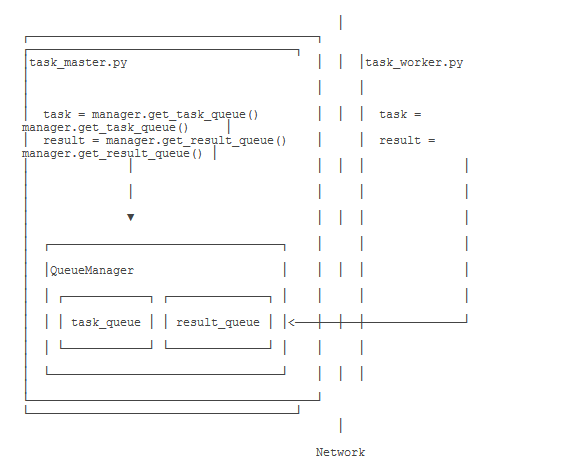

注意：Queue的作用是用来传递任务和接收结果，每个任务的描述数据量要尽量小。比如发送一个处理日志文件的任务，就不要发送几百兆的日志文件本身，而是发送日志文件存放的完整路径，由Worker进程再去共享的磁盘上读取文件。